### 채용사이트 잡플래닛의 데이터 분석
- 목적
    - 어떤 부분들이 회사의 가치를 높일 수 있는지 리뷰의 장점과 단점, value를 이용한 분석.
    - 회사의 사원 이탈율(퇴사자 수 / (입사자 수+퇴사자 수))와 value의 상관관계 분석.

- 데이터 설명
    - star_score : 별점
    - promotion	: 승진 기회 및 가능성
    - welfare_salary : 복지 및 급여
    - life_valance : 업무와 삶의 균형
    - culture : 사내문화
    - management : 경영진
    - company : 기업
    - content : 리뷰 제목
    - merit : 장점
    - disadvantages : 단점
    - want : 바라는 점

    - value : 리뷰글 개수 * 별점등의 평균값
    - inner : 2023년 입사자 수
    - outer : 2023년 퇴사자 수

- 아쉬운 점
    - 전직원, 현직원의 데이터로 대략적인 churn 분석이 불가능. 근속년수의 파악 불가
    - 연봉 칸에 있는 2023년 입사자 수, 2023년 퇴사자 수를 통한 churn 분석 약식 가능
        - 정확한 데이터가 아니긴 하지만, 잡플래닛의 데이터로 대략적인 이탈율 확인 가능.
        - 한 해의 churn 분석만 가능하므로 비교분석이 불가능.
    - 직원들의 근속년수를 모르기 때문에 cohort및 retention 분석이 힘듬

#### 1. 데이터 크롤링

In [1]:
import requests
import json
from bs4 import BeautifulSoup as bs

import pandas as pd
import numpy as np
import random
import os
import re

import datetime
import time

import asyncio
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Process, Queue

##### 1.1 랭킹 페이지를 통한 기업 리뷰, 연봉 링크 크롤링

In [2]:
# 회사 랭킹 페이지를 통한 a href 크롤링
site = 'https://www.jobplanet.co.kr'
url = 'https://www.jobplanet.co.kr/companies?sort_by=review_survey_total_avg_cache&page='

- 총 904페이지 존재.
- 기업 랭킹 한 페이지당 분석 시간이 약 3분이 걸리므로, 이 문서에서는 2페이지만 계산

In [3]:
# 비동기 웹 크롤링
loop = asyncio.get_event_loop()
# 전체 페이지 분석 -> 45시간 10분정도 소요 예상.
# urls = [url+str(i) for i in range(1,904)]
# 19페이지 분석 -> 1시간 소요 예상.
a_href_urls = (url+str(i) for i in range(1,20))
# 한페이지 분석 - 리뷰 데이터는 약 36초, 입퇴사자는 약 2분 20초 -> 총 3분.
a_href_urls = (url+str(i) for i in range(1,2))
a_href_urls = (url+str(i) for i in range(1,3))

async def a_href(url):
    loop = asyncio.get_event_loop()
    response = await loop.run_in_executor(None, requests.get, url)
    data = response.text
    soup = bs(data, 'html.parser')
    links = soup.select('.us_titb_l3 > a[href]')
    alinks = [site+link.attrs['href'] for link in links]
    return alinks

async def main(urls, func):
    result = np.array([])
    for i in [asyncio.create_task(f) for f in (func(url) for url in urls)]:
        await i
        result = np.append(result, i.result())
    return result

site_link = await main(a_href_urls, a_href)
print(site_link[:10])

['https://www.jobplanet.co.kr/companies/351150/info/%EC%84%B8%EC%9D%B4%EC%A7%80%EB%A6%AC%EC%84%9C%EC%B9%98?'
 'https://www.jobplanet.co.kr/companies/385866/info/%EA%B3%A8%EB%9D%BC%EB%9D%BC?'
 'https://www.jobplanet.co.kr/companies/347332/info/%ED%95%98%EB%A3%B9?'
 'https://www.jobplanet.co.kr/companies/92660/info/%EB%B0%B8%EB%9F%AC%EC%8A%A4?'
 'https://www.jobplanet.co.kr/companies/90364/info/%ED%8E%98%EC%9D%B4%EC%8A%A4%EB%B6%81%EC%BD%94%EB%A6%AC%EC%95%84?'
 'https://www.jobplanet.co.kr/companies/308098/info/%EA%B8%88%EC%9C%B5%EB%B3%B4%EC%95%88%EC%9B%90?'
 'https://www.jobplanet.co.kr/companies/112614/info/%EC%95%A0%ED%84%B0%EB%AF%B8?'
 'https://www.jobplanet.co.kr/companies/360493/info/%ED%95%AB%EC%85%80%EB%9F%AC?'
 'https://www.jobplanet.co.kr/companies/89723/info/%EB%9D%BC%EC%9D%B4%EC%97%87%EA%B2%8C%EC%9E%84%EC%A6%88%EC%BD%94%EB%A6%AC%EC%95%84?'
 'https://www.jobplanet.co.kr/companies/93022/info/%EC%9D%B5%EC%8A%A4%ED%94%BC%EB%94%94%EC%95%84%EC%BD%94%EB%A6%AC%EC%95%84?']


- 리뷰 데이터 주소 링크와 연봉 데이터 주소 링크로 데이터 변환

In [4]:
reviews_site = np.core.defchararray.replace(site_link, 'info', 'reviews')
salaries_site = np.core.defchararray.replace(site_link, 'info', 'salaries')
salaries_site[:10]

array(['https://www.jobplanet.co.kr/companies/351150/salaries/%EC%84%B8%EC%9D%B4%EC%A7%80%EB%A6%AC%EC%84%9C%EC%B9%98?',
       'https://www.jobplanet.co.kr/companies/385866/salaries/%EA%B3%A8%EB%9D%BC%EB%9D%BC?',
       'https://www.jobplanet.co.kr/companies/347332/salaries/%ED%95%98%EB%A3%B9?',
       'https://www.jobplanet.co.kr/companies/92660/salaries/%EB%B0%B8%EB%9F%AC%EC%8A%A4?',
       'https://www.jobplanet.co.kr/companies/90364/salaries/%ED%8E%98%EC%9D%B4%EC%8A%A4%EB%B6%81%EC%BD%94%EB%A6%AC%EC%95%84?',
       'https://www.jobplanet.co.kr/companies/308098/salaries/%EA%B8%88%EC%9C%B5%EB%B3%B4%EC%95%88%EC%9B%90?',
       'https://www.jobplanet.co.kr/companies/112614/salaries/%EC%95%A0%ED%84%B0%EB%AF%B8?',
       'https://www.jobplanet.co.kr/companies/360493/salaries/%ED%95%AB%EC%85%80%EB%9F%AC?',
       'https://www.jobplanet.co.kr/companies/89723/salaries/%EB%9D%BC%EC%9D%B4%EC%97%87%EA%B2%8C%EC%9E%84%EC%A6%88%EC%BD%94%EB%A6%AC%EC%95%84?',
       'https://www.jobplanet.co.kr/comp

##### 1.2 리뷰 데이터 크롤링

- 리뷰글을 보기 위한 로그인(로그인이 되어 있지 않으면 리뷰 글을 볼 수 없음)
- 현 문서에서는 가려놓았음

In [5]:
# 리뷰글을 보기 위한 로그인
session = requests.session()

def login(site, session):
    login_url = site+'/users/sign_in'
    email = '#############'
    pw = '############'
    LOGIN = {
        'user[email]' : email,
        'user[password]' : pw ,
        'commit' : '로그인'
    }
    resp = session.post(login_url, data=LOGIN, )
    resp.raise_for_status()
login(site, session)

- 데이터 클리닝

In [6]:
def text_clean(text):
    reg = re.compile('[ㄱ-ㅎㅏ-ㅣ0-9.,<>a-zA-Z!@#$%^&*?;~()\[\]\+·\"\'♡♥\-:]+')
    text = re.sub(pattern=reg, repl='', string=text)
    text = text.replace('\r', '. ')
    text = text.lstrip().rstrip()
    return text

- 리뷰의 마지막 페이지 수를 확인하기 위한 크롤링

In [7]:
def review_last_page(reviews_site):
    for reviews_s in reviews_site:
        resp = requests.get(reviews_s)
        data = resp.text
        soup = bs(data, 'html.parser')
        review_last_page = soup.select_one('#viewReviewsList > div > div > div > div.pg_bottom.um_paginnation > article > a.btn_pglast')
        review_last_page = int(review_last_page['href'][review_last_page['href'].rfind('=')+1:])
        yield review_last_page
        
last_page_nums = review_last_page(reviews_site)

- 리뷰 데이터 크롤링

In [8]:
# 리뷰글 갯수(index), 별점, 장점, 단점, 

review_info_urls = (url+'page='+str(i) for url, last_page_num in zip(reviews_site, last_page_nums) for i in range(1, last_page_num+1))
# for u in review_info_urls:
#     print(u)
async def review_info(url):
    result = list()
    loop = asyncio.get_event_loop()
    response = await loop.run_in_executor(None, session.get, url)
    data = response.text
    soup = bs(data, 'html.parser')
    # 리뷰 마지막 페이지 번호 수 확인
    review_last_page = soup.select_one('#viewReviewsList > div > div > div > div.pg_bottom.um_paginnation > article > a.btn_pglast')
    review_last_page = int(review_last_page.attrs['href'][review_last_page.attrs['href'].rfind('=')+1:])
    # 회사 이름
    company = soup.select_one('.company_name > .name').text
    # 리뷰 데이터 작성한 지원자 신원(분야, 현직원, 작성일))
    users_infos = soup.select('.content_top_ty2 > .txt1') # 4개의 종류
    # 별점
    star_scores = soup.select('.us_star_m > .star_score')
    # 승진 및 기회, 워라밸 등 5개의 평점
    prices = soup.select('.bl_score') # 5개의 종류
    # 제목
    contents = soup.select('.us_label')
    # 장단점, 바라는 점
    mds = soup.select('.tc_list > .df1 > span') # 3개의 종류로 되어있음
    
    for i in range(len(star_scores)):
        # 별점
        star_score = int(star_scores[i]['style'][6:-2])/20
        # 평가 항목들
        promotion = int(prices[i*5]['style'][6:-2])/20
        welfare_salary = int(prices[i*5+1]['style'][6:-2])/20
        life_valance = int(prices[i*5+2]['style'][6:-2])/20
        culture = int(prices[i*5+3]['style'][6:-2])/20
        management = int(prices[i*5+4]['style'][6:-2])/20
        # 제목
        content = text_clean(contents[i].text)
        # 장단점
        merit = text_clean(mds[i*3].text)
        disadvantages = text_clean(mds[i*3+1].text)
        want = text_clean(mds[i*3+2].text)
        # 유저 정보
        # position = text_clean(users_infos[i*4].text)
        # status = text_clean(users_infos[i*4+1].text)
        # location = text_clean(users_infos[i*4+2].text)
        # try:
        #     date = users_infos[i*4+3].text
        # except:
        #     date = None

        result.append([
            star_score,
            promotion,
            welfare_salary,
            life_valance,
            culture,
            management,
            company,
            content,
            merit,
            disadvantages,
            want,
            # position,
            # status,
            # location,
            # date,
            ])
    return result

- 리뷰 데이터 크롤링 시작

In [9]:
# 한페이지 기업(10개의 기업) 리뷰 데이터 크롤링 시 약 36.5초 걸림(540개의 리뷰 데이터)
review_info_data = await main(review_info_urls, review_info)
print(review_info_data[:10])

['5.0' '5.0' '4.0' '5.0' '5.0' '5.0' '세이지리서치(주)'
 '무한한 발전 가능성이 있으며 뛰어난  만화가를 배출한  업계의 진정한 유망주 끊임 없는 도전과 연구를 바탕으로 머신러닝 역사에 한 획을 긋는 실력 있는 기업 세이지리서치'
 '명절 복지가 뛰어납니다 인턴인데 집에 한우가 와서 집에서 당황했을 정도입니다. 기업 문화가 정말 수평적입니다 직급간 위화감이 없습니다 직급이 있는지도 모르겠습니다.  역세권에 있습니다 서초역에서 분 거리에 있습니다.  멤버들이 이끌어가는 회사 사내 구성원의 의견을 모두 존중하는 문화가 있습니다 자유로운 의견 제시를 위한 사내 행사 제도 등이 존재하며 수렴한 의견을 바탕으로 회사 내규와 회사의 비전을 개선하기 위해 경영진이 항상 노력합니다.  회사와 함께 성장하는 즐거움 스타트업 회사 세이지는 직원과 함께 발전하고 성장해갑니다 세이지리서치에서는 직원의 성장하면 회사가 성장하고 회사가 성장하면 직원이 성장합니다'
 '회사 주변 물가가 서울의 타 지역에 비해 비쌉니다 법조인 분들 월급 수준에 맞게 상향 조정 되어 있는 것 같습니다. 회사 근처에 대법원이 있는지라 시위 때문에 조금 시끄럽습니다. 저녁에 회사 창 밖으로 노을이 너무 잘 보여 일에 집중하기 어렵습니다. 기업 내부의 단점 그런 것은 없습니다']


##### 1.3 입사자 및 퇴사자 수 크롤링

- 입사자 및 퇴사자 수 데이터 다운
- session 거부를 피하기 위해 비동기, 스레딩 사용 x
- 동적 데이터라 selenium을 이용하여 데이터 크롤링

In [10]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.edge.options import Options

# 입사자, 퇴사자 수 체크 joined, left
def join_left(url):
    options = Options()
    options.add_argument("headless")
    edge_path = r'C:/msedgedriver.exe'
    driver = webdriver.Edge(edge_path, options=options)
    driver.get(url)
    
    company = '/html/body/div[1]/div[2]/div[1]/div/div[2]/div/div/div[1]/div[2]/div[1]/h1/a'
    inner = '//*[@id="sideContents"]/div[2]/div/div[2]/div[2]/em'
    outer = '//*[@id="sideContents"]/div[2]/div/div[3]/div[2]/em'
    company = driver.find_element(By.XPATH, company).text
    try:
        inner = driver.find_element(By.XPATH, inner).text
        outer = driver.find_element(By.XPATH, outer).text
        
        result = [company, inner, outer]
    except:
        result = [company, None, None]
    print(result)
    time.sleep(5)
    driver.quit()

    return result

In [11]:
# 한 페이지의 기업 입퇴사자 분석시 약 2분 20초가 걸림(10개의 기업)
result = np.array([])
for s in salaries_site:
    result = np.append(result, join_left(s))
print(result)

C:\Users\su\AppData\Local\Temp/ipykernel_18140/793128053.py:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Edge(edge_path, options=options)


['세이지리서치(주)', '1', '0']
['(주)골라라', '0', '2']
['(주)하룹', '2', '1']
['(유)밸러스', '0', '0']
['페이스북코리아(유)', '1', '4']
['(사)금융보안원', '6', '4']
['애터미(주)', '8', '4']
['(주)핫셀러', '12', '6']
['라이엇게임즈코리아', None, None]
['(주)익스피디아코리아', '1', '2']
['(주)케이에스에스해운', '9', '5']
['경동도시가스(주)', None, None]
['(주)페이타랩', '6', '3']
['브라운백(주)', '0', '8']
['네이버웹툰', '26', '15']
['구글코리아(유)', '27', '26']
['(주)넥슨게임즈', '58', '16']
['(주)트레드링스', '4', '2']
['맥킨지인코포레이티드한국지점', None, None]
['한국중부발전(주)', '167', '56']
['세이지리서치(주)' '1' '0' '(주)골라라' '0' '2' '(주)하룹' '2' '1' '(유)밸러스' '0' '0'
 '페이스북코리아(유)' '1' '4' '(사)금융보안원' '6' '4' '애터미(주)' '8' '4' '(주)핫셀러' '12'
 '6' '라이엇게임즈코리아' None None '(주)익스피디아코리아' '1' '2' '(주)케이에스에스해운' '9' '5'
 '경동도시가스(주)' None None '(주)페이타랩' '6' '3' '브라운백(주)' '0' '8' '네이버웹툰' '26'
 '15' '구글코리아(유)' '27' '26' '(주)넥슨게임즈' '58' '16' '(주)트레드링스' '4' '2'
 '맥킨지인코포레이티드한국지점' None None '한국중부발전(주)' '167' '56']


#### 2. 데이터 정형 및 분석

##### 2.1 데이터 정형

- dataframe으로 변경하기 위한 데이터 정형

In [12]:
# 리뷰 데이터 정형
columns_num = 11
review_info_data=np.reshape(review_info_data,(review_info_data.shape[0]// columns_num, columns_num))

In [13]:
# 입퇴사자 데이터 정형
columns_num = 3
join_left_data=np.reshape(result,(result.shape[0]// columns_num, columns_num))

- data to dataframe

- 리뷰 데이터

In [14]:
# 리뷰데이터 to dataframe
review_columns = [
    'star_score',
    'promotion',
    'welfare_salary',
    'life_valance',
    'culture',
    'management',
    'company',
    'content',
    'merit',
    'disadvantages',
    'want',
    # 'position',
    # 'status',
    # 'location',
    # 'date',
    ]
            
df_review = pd.DataFrame(data=review_info_data, columns=review_columns)
df_review.head()

,star_score,promotion,welfare_salary,life_valance,culture,management,company,content,merit,disadvantages,want
0,5.0,5.0,4.0,5.0,5.0,5.0,세이지리서치(주),무한한 발전 가능성이 있으며 뛰어난 만화가를 배출한 업계의 진정한 유망주 끊임 ...,명절 복지가 뛰어납니다 인턴인데 집에 한우가 와서 집에서 당황했을 정도입니다. 기업...,회사 주변 물가가 서울의 타 지역에 비해 비쌉니다 법조인 분들 월급 수준에 맞게 상...,기업 발전을 위해 불철주야 노력해주셔서 감사합니다
1,5.0,5.0,5.0,5.0,5.0,5.0,세이지리서치(주),직원 복지와 자기계발에 매우 적극적이고 다양한 기회를 제공해주는 회사 복지 최고,온보딩을 기초로 입사부터 체계적으로 회사에 적응할 수 있는 환경을 만들어 줍니다 다...,매출 규모가 작음 다양한 거래처 및 영업 확장이 필요합니다 그 외 딱히 단점은 없습니다,상품의 다양한 마케팅을 통해 매출 커브 성장이 이뤄졌으면 좋겠습니다
2,5.0,5.0,5.0,5.0,5.0,5.0,세이지리서치(주),초기 스타트업에서 체계를 만들어나가는 것을 즐기는 사람에게 추천,똑똑한 팀원들 수평적인 업무 분위기 도움이 필요할 때 손을 내미면 다들 적극적으로 ...,딱히 떠오르는 것은 없음 하나 꼽자면 재택근무가 불가능 그런데 유연근무제나 자리비움...,타임라인이 타이트하다는 것 외에는 크게 바라는 것 없고 이대로 쭉 잘 해나가서 계속...
3,5.0,5.0,5.0,5.0,5.0,5.0,세이지리서치(주),테크 기반의 강한 기술력이 있는 엔지니어들과 도메인 전문가들이 시장에서 인정받는 제...,스타트업이라 회사 성장과 목표 액션플랜을 구체화하는 단계에서 구성원들이 많은 제안을...,모든 스타트업들의 공통된 어려움처럼 체계화를 하는 과정에서 의견 교류가 많다보니 오...,좋은 분위기에서 의미있는 결과를 만들기 위해서 더 노력할 수 있도록 지금 조직 문화...
4,5.0,5.0,5.0,5.0,5.0,5.0,세이지리서치(주),업무 만족스럽고 동료 만족스럽고 복지 만족스럽고… 흠잡을 데 없이 좋은 회사 원격 ...,수평적이고 자유로운 분위기 나날이 좋아지는 복지와 지원 성장하기 좋은 환경,근무 제도가 유연한 편이지만 옥에티라면 재택근무 제도가 없다는 점 정도 구성원 수에...,요즘 신규 고객 유치나 평가보상제도 마련에 많이 분주할 것 같은데 지금까지 해온 대...


- 입퇴사자 데이터

In [15]:
# 입퇴사자 to dataframe
jl_columns =['company', 'inner', 'outer']
df_jl = pd.DataFrame(data=join_left_data, columns=jl_columns)
df_jl.head()

,company,inner,outer
0,세이지리서치(주),1,0
1,(주)골라라,0,2
2,(주)하룹,2,1
3,(유)밸러스,0,0
4,페이스북코리아(유),1,4


##### 2.2 데이터 cf 분석

- cf분석을 통한 단어별 가치 측정

In [16]:
import os
import numpy as np
from konlpy.tag import Okt

from nltk import Text
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

c:\Users\su\anaconda3\envs\vision\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
okt = Okt()

async def cf_count(text):
    loop = asyncio.get_event_loop()
    result = await loop.run_in_executor(None, okt.nouns, text)
    return result

async def cf_count_main(script, func):
    result = np.array([])
    for i in [asyncio.create_task(func(text)) for text in script]:
        await i
        result = np.append(result, i.result())
    return result

- cf 분석

In [18]:
# df_review.columns.values
df_jl.company.unique()
dt_lists = ['content', 'merit', 'disadvantages', 'want']
result = dict()
for dl in dt_lists:
    result[dl] = list()
    for cp_name in df_jl.company.values:
        dt = df_review[df_review.company == cp_name][dl].values
        cf = await cf_count_main(dt, cf_count)
        cf = pd.Series(cf)
        # print(list(zip(cf.value_counts().head(20).index, cf.value_counts().head(20).values)))
        temp = cf.value_counts().head(20)
        result[dl].append(temp)


In [19]:
temp = pd.DataFrame(result)
temp.head()

,content,merit,disadvantages,want
0,회사 14 복지 5 분위기 5 기업 5 성장...,지원 16 회사 15 복지 15 분위기 13 수 ...,시니어 8 회사 7 수 7 체계 6 것 ...,것 10 지금 6 더 4 평가 3 성과 3 노...
1,회사 11 수 9 일 7 문화 6 곳 ...,수 14 연차 12 시 11 시간 10 사용...,업무 5 부분 5 개발 4 시간 4 체계 ...,회사 12 더 5 수 5 생각 5 업무 4 시...
2,회사 23 복지 12 분위기 8 직원 8 곳 ...,직원 21 회사 21 복지 16 매우 14 사람...,직원 20 회사 16 곳 16 사람 12 업무 10 때...,직원 13 회사 10 더 6 사람 6 영진 5 인...
3,회사 10 수 10 컨설팅 9 일 5 인사...,수 18 일 13 것 11 회사 10 컨설...,프로젝트 11 수 11 일 8 업무 7 경우...,회사 5 일 5 생각 4 시간 4 정말 4 그...
4,회사 44 기업 34 수 28 일 22 곳 ...,수 69 회사 53 문화 36 복지 29 기업 ...,업무 29 수 28 회사 27 것 25 일 ...,더 26 회사 19 직원 16 것 16 수 16 문...


In [20]:
temp['company'] = df_jl.company.values

- 입퇴사자 데이터와, text cf분석을 진행한 dataframe merge.

In [21]:
sample_set_df = df_jl.merge(
    temp, 
    how='left',
    on='company',
)
sample_set_df.head()

,company,inner,outer,content,merit,disadvantages,want
0,세이지리서치(주),1,0,회사 14 복지 5 분위기 5 기업 5 성장...,지원 16 회사 15 복지 15 분위기 13 수 ...,시니어 8 회사 7 수 7 체계 6 것 ...,것 10 지금 6 더 4 평가 3 성과 3 노...
1,(주)골라라,0,2,회사 11 수 9 일 7 문화 6 곳 ...,수 14 연차 12 시 11 시간 10 사용...,업무 5 부분 5 개발 4 시간 4 체계 ...,회사 12 더 5 수 5 생각 5 업무 4 시...
2,(주)하룹,2,1,회사 23 복지 12 분위기 8 직원 8 곳 ...,직원 21 회사 21 복지 16 매우 14 사람...,직원 20 회사 16 곳 16 사람 12 업무 10 때...,직원 13 회사 10 더 6 사람 6 영진 5 인...
3,(유)밸러스,0,0,회사 10 수 10 컨설팅 9 일 5 인사...,수 18 일 13 것 11 회사 10 컨설...,프로젝트 11 수 11 일 8 업무 7 경우...,회사 5 일 5 생각 4 시간 4 정말 4 그...
4,페이스북코리아(유),1,4,회사 44 기업 34 수 28 일 22 곳 ...,수 69 회사 53 문화 36 복지 29 기업 ...,업무 29 수 28 회사 27 것 25 일 ...,더 26 회사 19 직원 16 것 16 수 16 문...


##### 2.3 기업 가치 측정 및 이탈율 분석

- 가치가 높은 기업일 수록 이탈율이 적을 것이라 가정.
- star_score, promotion, welfare_salary, life_valance, culture, management 컬럼들 float type으로 변경

In [22]:
df_review_float_columns = ['star_score', 'promotion', 'welfare_salary', 'life_valance', 'culture', 'management']
df_review[df_review_float_columns] = df_review[df_review_float_columns].astype(float)
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   star_score      1487 non-null   float64
 1   promotion       1487 non-null   float64
 2   welfare_salary  1487 non-null   float64
 3   life_valance    1487 non-null   float64
 4   culture         1487 non-null   float64
 5   management      1487 non-null   float64
 6   company         1487 non-null   object 
 7   content         1487 non-null   object 
 8   merit           1487 non-null   object 
 9   disadvantages   1487 non-null   object 
 10  want            1487 non-null   object 
dtypes: float64(6), object(5)
memory usage: 127.9+ KB


- 기업 가치 측정 및 이탈율 측정
    - values = 리뷰글 갯수 * (star_score, promotion, welfare_salary, life_valance, culture, management)의 평균 값
    - staaars = (star_score, promotion, welfare_salary, life_valance, culture, management)의 평균 값
    - churn = 퇴사자 수 / (입사자 수 + 퇴사자 수)
        - 직원의 입사시기, 퇴사시기, 근속년수 등을 알 수가 없음.

In [23]:
staaars = [df_review[df_review.company == c].mean(numeric_only=True).mean() for c in df_jl.company.values]
values = [df_review[df_review.company == c].count()[0]*df_review[df_review.company == c].mean(numeric_only=True).mean() for c in df_jl.company.values]
sample_set_df['values'] = values
sample_set_df['staaars'] = staaars
sample_set_df['churn'] = (sample_set_df.outer.astype('float') + 1e-5) / (sample_set_df.inner.astype('float') + sample_set_df.outer.astype('float') + 1e-5)
sample_set_df.head(10)
# df_review.describe()

,company,inner,outer,content,merit,disadvantages,want,values,staaars,churn
0,세이지리서치(주),1,0,회사 14 복지 5 분위기 5 기업 5 성장...,지원 16 회사 15 복지 15 분위기 13 수 ...,시니어 8 회사 7 수 7 체계 6 것 ...,것 10 지금 6 더 4 평가 3 성과 3 노...,99.000000,4.714286,0.000010
1,(주)골라라,0,2,회사 11 수 9 일 7 문화 6 곳 ...,수 14 연차 12 시 11 시간 10 사용...,업무 5 부분 5 개발 4 시간 4 체계 ...,회사 12 더 5 수 5 생각 5 업무 4 시...,91.500000,4.575000,1.000000
2,(주)하룹,2,1,회사 23 복지 12 분위기 8 직원 8 곳 ...,직원 21 회사 21 복지 16 매우 14 사람...,직원 20 회사 16 곳 16 사람 12 업무 10 때...,직원 13 회사 10 더 6 사람 6 영진 5 인...,87.000000,4.142857,0.333336
3,(유)밸러스,0,0,회사 10 수 10 컨설팅 9 일 5 인사...,수 18 일 13 것 11 회사 10 컨설...,프로젝트 11 수 11 일 8 업무 7 경우...,회사 5 일 5 생각 4 시간 4 정말 4 그...,83.000000,4.150000,1.000000
4,페이스북코리아(유),1,4,회사 44 기업 34 수 28 일 22 곳 ...,수 69 회사 53 문화 36 복지 29 기업 ...,업무 29 수 28 회사 27 것 25 일 ...,더 26 회사 19 직원 16 것 16 수 16 문...,347.500000,4.290123,0.800000
5,(사)금융보안원,6,4,회사 26 보안 23 금융 22 수 15 곳 ...,복지 25 연봉 23 금융 21 워 15 분위기 ...,위치 16 금융 14 회사 12 보수 9 문화 ...,직원 23 수 10 좀 9 회사 9 영진 8 및...,230.833333,4.122024,0.400001
6,애터미(주),8,4,회사 72 기업 42 수 42 곳 31 사람 ...,복지 49 회사 45 업무 39 수 36 직원 ...,업무 32 수 28 일 26 회사 25 위치 ...,직원 38 회사 24 지금 20 수 20 것 20 생...,440.500000,4.235577,0.333334
7,(주)핫셀러,12,6,회사 76 수 51 곳 32 성장 18 기업 15 직...,수 97 회사 80 지원 60 식대 48 무제한 ...,업무 55 수 44 때 43 사람 35 회사 ...,더 37 직원 27 수 24 것 24 생각 ...,405.500000,4.223958,0.333334
8,라이엇게임즈코리아,None,None,회사 42 게임 25 일 22 기업 17 수 ...,회사 39 수 33 게임 28 문화 25 업무 ...,게임 24 사람 21 수 19 회사 18 업무 17 것...,직원 20 지금 16 회사 13 수 11 것 10 복...,308.333333,4.111111,NaN
9,(주)익스피디아코리아,1,2,회사 15 최고 14 워 13 연봉 12 밸 ...,연봉 16 업계 13 분위기 11 회사 11 워 ...,회사 16 외국 12 업무 12 승진 11 한국 11 함...,좀 11 한국 10 더 10 직원 9 수 ...,188.000000,4.086957,0.666668


- 가치를 기준으로 한 회사 순위

In [24]:
sample_set_df.sort_values('values', ascending=False).head(10)

,company,inner,outer,content,merit,disadvantages,want,values,staaars,churn
19,한국중부발전(주),167,56,회사 100 공기업 82 근무 81 기업 53 수 ...,연봉 90 분위기 84 공기업 81 업무 7...,근무 127 보령 89 단점 71 오지 59 것 ...,직원 58 인턴 46 더 43 회사 42 것 ...,1370.166667,4.177337,0.251121
15,구글코리아(유),27,26,회사 96 기업 69 수 67 곳 56 일 ...,수 109 복지 75 사람 63 문화 59 일 ...,사람 51 수 48 일 46 업무 41 한국 37 것...,더 69 것 43 한국 39 구글 33 회사 ...,931.833333,4.235606,0.490566
6,애터미(주),8,4,회사 72 기업 42 수 42 곳 31 사람 ...,복지 49 회사 45 업무 39 수 36 직원 ...,업무 32 수 28 일 26 회사 25 위치 ...,직원 38 회사 24 지금 20 수 20 것 20 생...,440.500000,4.235577,0.333334
18,맥킨지인코포레이티드한국지점,None,None,회사 49 수 43 곳 38 최고 37 컨설팅 ...,수 98 일 55 회사 39 사람 26 글로...,업무 37 수 31 워 30 일 29 강도...,더 29 수 29 것 23 회사 18 프로...,440.333333,3.862573,NaN
14,네이버웹툰,26,15,수 36 회사 32 곳 27 일 24 분위기 ...,수 42 분위기 35 복지 33 업무 26 네이버 ...,업무 30 수 25 사람 19 것 16 워 ...,더 29 것 20 직원 18 회사 15 수 ...,416.000000,4.078431,0.365854
7,(주)핫셀러,12,6,회사 76 수 51 곳 32 성장 18 기업 15 직...,수 97 회사 80 지원 60 식대 48 무제한 ...,업무 55 수 44 때 43 사람 35 회사 ...,더 37 직원 27 수 24 것 24 생각 ...,405.500000,4.223958,0.333334
4,페이스북코리아(유),1,4,회사 44 기업 34 수 28 일 22 곳 ...,수 69 회사 53 문화 36 복지 29 기업 ...,업무 29 수 28 회사 27 것 25 일 ...,더 26 회사 19 직원 16 것 16 수 16 문...,347.500000,4.290123,0.800000
8,라이엇게임즈코리아,None,None,회사 42 게임 25 일 22 기업 17 수 ...,회사 39 수 33 게임 28 문화 25 업무 ...,게임 24 사람 21 수 19 회사 18 업무 17 것...,직원 20 지금 16 회사 13 수 11 것 10 복...,308.333333,4.111111,NaN
5,(사)금융보안원,6,4,회사 26 보안 23 금융 22 수 15 곳 ...,복지 25 연봉 23 금융 21 워 15 분위기 ...,위치 16 금융 14 회사 12 보수 9 문화 ...,직원 23 수 10 좀 9 회사 9 영진 8 및...,230.833333,4.122024,0.400001
10,(주)케이에스에스해운,9,5,회사 42 수 15 안정 13 기업 12 직원 ...,회사 27 업무 21 수 20 연차 19 직원 ...,업무 24 회사 17 직원 14 수 10 분위기 ...,회사 21 직원 20 것 10 함 10 생각 9 더...,227.000000,4.127273,0.357143


- 이탈율을 기준으로 한 회사 순위

In [25]:
sample_set_df.sort_values('churn', ascending=True).head(10)

,company,inner,outer,content,merit,disadvantages,want,values,staaars,churn
0,세이지리서치(주),1,0,회사 14 복지 5 분위기 5 기업 5 성장...,지원 16 회사 15 복지 15 분위기 13 수 ...,시니어 8 회사 7 수 7 체계 6 것 ...,것 10 지금 6 더 4 평가 3 성과 3 노...,99.000000,4.714286,0.000010
16,(주)넥슨게임즈,58,16,회사 14 수 7 개발 6 게임 5 넥슨...,복지 12 회사 10 개발 9 프로젝트 7 분위...,단점 4 지역 4 판교 4 서울 4 복지 ...,회사 5 프로젝트 4 더 4 수 4 앞 ...,90.833333,4.128788,0.216216
19,한국중부발전(주),167,56,회사 100 공기업 82 근무 81 기업 53 수 ...,연봉 90 분위기 84 공기업 81 업무 7...,근무 127 보령 89 단점 71 오지 59 것 ...,직원 58 인턴 46 더 43 회사 42 것 ...,1370.166667,4.177337,0.251121
7,(주)핫셀러,12,6,회사 76 수 51 곳 32 성장 18 기업 15 직...,수 97 회사 80 지원 60 식대 48 무제한 ...,업무 55 수 44 때 43 사람 35 회사 ...,더 37 직원 27 수 24 것 24 생각 ...,405.500000,4.223958,0.333334
6,애터미(주),8,4,회사 72 기업 42 수 42 곳 31 사람 ...,복지 49 회사 45 업무 39 수 36 직원 ...,업무 32 수 28 일 26 회사 25 위치 ...,직원 38 회사 24 지금 20 수 20 것 20 생...,440.500000,4.235577,0.333334
12,(주)페이타랩,6,3,회사 21 곳 14 성장 12 수 10 사람...,지원 24 수 22 분위기 19 연차 14 교통...,업무 12 회사 11 수 9 체계 8 스타...,회사 16 더 16 지금 10 것 9 수 ...,140.166667,4.247475,0.333334
17,(주)트레드링스,4,2,회사 14 물류 11 수 10 기업 6 경험 ...,수 11 분위기 10 사용 8 기업 7 업무 ...,업무 11 대한 8 체계 7 직원 6 것 ...,직원 13 수 9 회사 7 더 6 이야기 ...,85.500000,3.886364,0.333334
2,(주)하룹,2,1,회사 23 복지 12 분위기 8 직원 8 곳 ...,직원 21 회사 21 복지 16 매우 14 사람...,직원 20 회사 16 곳 16 사람 12 업무 10 때...,직원 13 회사 10 더 6 사람 6 영진 5 인...,87.000000,4.142857,0.333336
10,(주)케이에스에스해운,9,5,회사 42 수 15 안정 13 기업 12 직원 ...,회사 27 업무 21 수 20 연차 19 직원 ...,업무 24 회사 17 직원 14 수 10 분위기 ...,회사 21 직원 20 것 10 함 10 생각 9 더...,227.000000,4.127273,0.357143
14,네이버웹툰,26,15,수 36 회사 32 곳 27 일 24 분위기 ...,수 42 분위기 35 복지 33 업무 26 네이버 ...,업무 30 수 25 사람 19 것 16 워 ...,더 29 것 20 직원 18 회사 15 수 ...,416.000000,4.078431,0.365854


##### 2.4 기업 가치와 이탈율의 상관관계 분석

- 히트맵을 통한 가치와 이탈율의 상관관계 분석

Text(0.5, 1.0, 'screen heatmap')

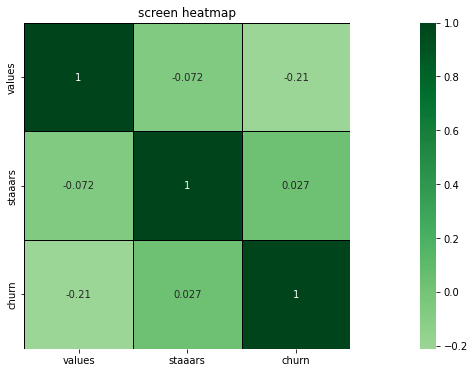

In [26]:
plt.figure(figsize=(25,6))
cmap = 'Greens'
sns.heatmap(sample_set_df.corr(numeric_only=True),cmap=cmap,square=True,linewidths=.5,center=0,linecolor="black", annot=True)
plt.title("screen heatmap")

- 해당 문서에서 계산한 가치와 이탈율은 큰 상관 관계가 없으며, 만약 사용자의 입사년도, 퇴사년도, 근속년도를 다 알 수 있었다면, 상관 관계가 좀 더 높아졌을 수도 있을거라 생각함.
- 따라서 해당 문서에서 이탈율은 '가치'보다 데이터를 분석할 때 용이하지 않음을 확인

##### 2.5 기업 리뷰 장점과 단점의 CF 분석을 통한 기업 분석

- 가치를 기준으로 한 회사 상위 10개 분석

In [27]:
# 상위 10개의 기업들만 추출
final = sample_set_df.sort_values('values', ascending=False).head(10)
final

,company,inner,outer,content,merit,disadvantages,want,values,staaars,churn
19,한국중부발전(주),167,56,회사 100 공기업 82 근무 81 기업 53 수 ...,연봉 90 분위기 84 공기업 81 업무 7...,근무 127 보령 89 단점 71 오지 59 것 ...,직원 58 인턴 46 더 43 회사 42 것 ...,1370.166667,4.177337,0.251121
15,구글코리아(유),27,26,회사 96 기업 69 수 67 곳 56 일 ...,수 109 복지 75 사람 63 문화 59 일 ...,사람 51 수 48 일 46 업무 41 한국 37 것...,더 69 것 43 한국 39 구글 33 회사 ...,931.833333,4.235606,0.490566
6,애터미(주),8,4,회사 72 기업 42 수 42 곳 31 사람 ...,복지 49 회사 45 업무 39 수 36 직원 ...,업무 32 수 28 일 26 회사 25 위치 ...,직원 38 회사 24 지금 20 수 20 것 20 생...,440.500000,4.235577,0.333334
18,맥킨지인코포레이티드한국지점,None,None,회사 49 수 43 곳 38 최고 37 컨설팅 ...,수 98 일 55 회사 39 사람 26 글로...,업무 37 수 31 워 30 일 29 강도...,더 29 수 29 것 23 회사 18 프로...,440.333333,3.862573,NaN
14,네이버웹툰,26,15,수 36 회사 32 곳 27 일 24 분위기 ...,수 42 분위기 35 복지 33 업무 26 네이버 ...,업무 30 수 25 사람 19 것 16 워 ...,더 29 것 20 직원 18 회사 15 수 ...,416.000000,4.078431,0.365854
7,(주)핫셀러,12,6,회사 76 수 51 곳 32 성장 18 기업 15 직...,수 97 회사 80 지원 60 식대 48 무제한 ...,업무 55 수 44 때 43 사람 35 회사 ...,더 37 직원 27 수 24 것 24 생각 ...,405.500000,4.223958,0.333334
4,페이스북코리아(유),1,4,회사 44 기업 34 수 28 일 22 곳 ...,수 69 회사 53 문화 36 복지 29 기업 ...,업무 29 수 28 회사 27 것 25 일 ...,더 26 회사 19 직원 16 것 16 수 16 문...,347.500000,4.290123,0.800000
8,라이엇게임즈코리아,None,None,회사 42 게임 25 일 22 기업 17 수 ...,회사 39 수 33 게임 28 문화 25 업무 ...,게임 24 사람 21 수 19 회사 18 업무 17 것...,직원 20 지금 16 회사 13 수 11 것 10 복...,308.333333,4.111111,NaN
5,(사)금융보안원,6,4,회사 26 보안 23 금융 22 수 15 곳 ...,복지 25 연봉 23 금융 21 워 15 분위기 ...,위치 16 금융 14 회사 12 보수 9 문화 ...,직원 23 수 10 좀 9 회사 9 영진 8 및...,230.833333,4.122024,0.400001
10,(주)케이에스에스해운,9,5,회사 42 수 15 안정 13 기업 12 직원 ...,회사 27 업무 21 수 20 연차 19 직원 ...,업무 24 회사 17 직원 14 수 10 분위기 ...,회사 21 직원 20 것 10 함 10 생각 9 더...,227.000000,4.127273,0.357143


- 장점 리뷰 분석

In [28]:
# 한글 사용
import matplotlib.pyplot as plt
import platform
import seaborn as sns

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': # 맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':# 윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

In [29]:
# 장점 분석
merit_words = dict()
for mer in final.merit.values:
    for text, num in mer.items():
        merit_words[text] = merit_words.get(text, 0) + num
        
merit_words = dict(sorted(merit_words.items(), key=lambda item: item[1], reverse=True))
# 불용어 제거
del merit_words['수']
del merit_words['회사']
del merit_words['등']
del merit_words['워']
del merit_words['것']
# merit_words

In [30]:
# 상위 10개의 단어만 추출
import itertools
merit_words = dict(itertools.islice(merit_words.items(), 10))
merit_words

{'복지': 358,
 '업무': 309,
 '분위기': 271,
 '문화': 229,
 '일': 217,
 '연차': 212,
 '사람': 179,
 '직원': 163,
 '연봉': 159,
 '기업': 128}

Text(0, 0.5, 'count')

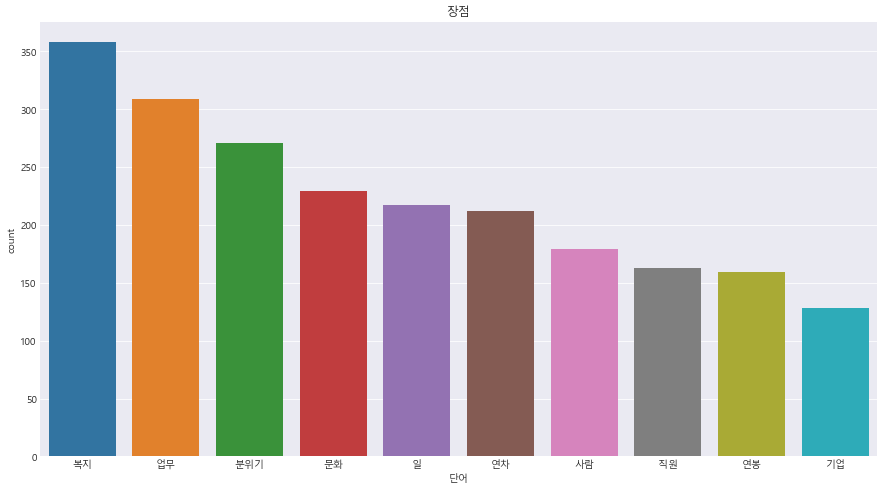

In [31]:
plt.figure(figsize=(15,8))
sns.barplot(x=list(merit_words.keys()), y=list(merit_words.values()))
plt.title("장점")
plt.xlabel("단어")
plt.ylabel("count")

- 복지와 업무, 분위기, 일, 연차, 사람, 연봉 등이 상위 단어에 나열되어 있는것을 보니, 워라벨과 직원들간의 분위기 등이 좋은 회사일수록 좋은 가치를 지님을 확인할 수 있음

- 단점 리뷰 분석

In [32]:
# 단점 분석
disadvantages_words = dict()
for dis in final.disadvantages.values:
    for text, num in dis.items():
        disadvantages_words[text] = disadvantages_words.get(text, 0) + num
        
disadvantages_words = dict(sorted(disadvantages_words.items(), key=lambda item: item[1], reverse=True))
# 불용어 제거
del disadvantages_words['수']
del disadvantages_words['회사']
del disadvantages_words['함']
del disadvantages_words['워']
del disadvantages_words['것']
del disadvantages_words['단점']
del disadvantages_words['때']
del disadvantages_words['때문']
del disadvantages_words['경우']
# disadvantages_words

In [33]:
# 상위 10개의 단어만 추출
import itertools
disadvantages_words = dict(itertools.islice(disadvantages_words.items(), 10))
disadvantages_words

{'업무': 314,
 '사람': 222,
 '일': 182,
 '근무': 145,
 '문화': 125,
 '생각': 99,
 '보령': 89,
 '직원': 75,
 '부서': 70,
 '오지': 59}

Text(0, 0.5, 'count')

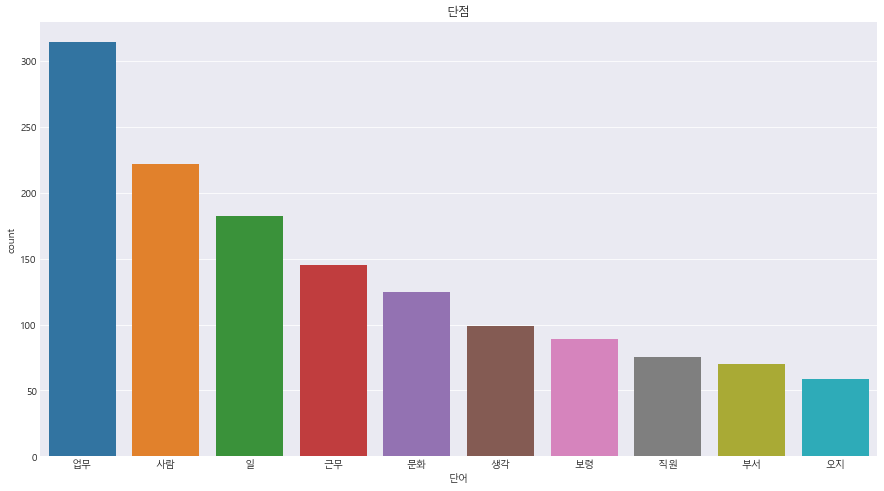

In [34]:
plt.figure(figsize=(15,8))
sns.barplot(x=list(disadvantages_words.keys()), y=list(disadvantages_words.values()))
plt.title("단점")
plt.xlabel("단어")
plt.ylabel("count")

- 보령, 오지, 지방 등을 합치면 일보다 많음을 확인할 수 있으므로, 거리가 사람 다음으로 큰 단점으로 측정될 수 있음
- 업무와 사람, 일, 근무, 문화, 거리 순으로 나열되어 있는 것을 보면 장점과 마찬가지로 단점도 워라밸이라고 꼽을 수 있음.

- 회사에게 원하는 리뷰 글 분석

In [45]:
# 단점 분석
want_words = dict()
for wa in final.want.values:
    for text, num in wa.items():
        want_words[text] = want_words.get(text, 0) + num
        
want_words = dict(sorted(want_words.items(), key=lambda item: item[1], reverse=True))
# 불용어 제거
del want_words['수']
del want_words['한국']
del want_words['함']
del want_words['워']
del want_words['것']
del want_words['때']
del want_words['더']
del want_words['지금']
del want_words['좀']
del want_words['점']
del want_words['앞']
# want_words

In [46]:
# 상위 10개의 단어만 추출
import itertools
want_words = dict(itertools.islice(want_words.items(), 10))
want_words

{'직원': 258,
 '회사': 214,
 '생각': 101,
 '문화': 76,
 '업무': 74,
 '복지': 74,
 '사업': 51,
 '기업': 48,
 '인턴': 46,
 '영진': 40}

Text(0, 0.5, 'count')

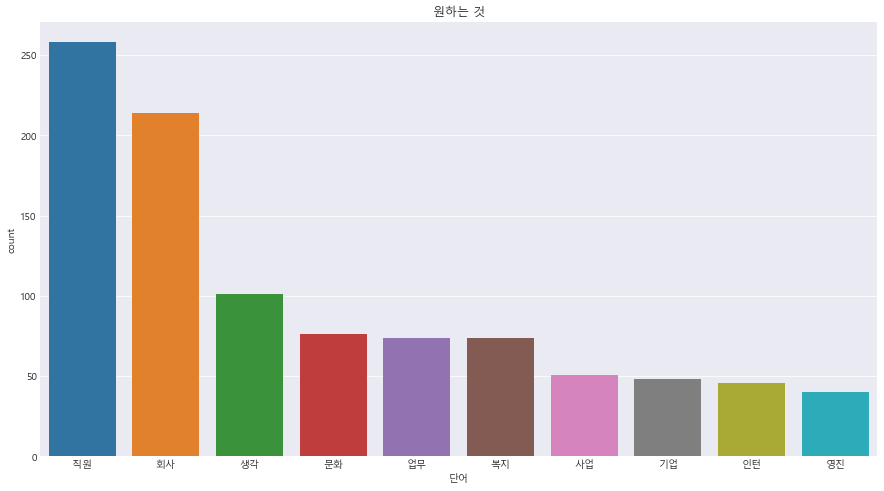

In [47]:
plt.figure(figsize=(15,8))
sns.barplot(x=list(want_words.keys()), y=list(want_words.values()))
plt.title("원하는 것")
plt.xlabel("단어")
plt.ylabel("count")

- 기업에게 바라는 글이라, 직원과 회사, 생각해줬으면 좋겠다는 키워드가 많음
- 문화, 업무 복지 등 직원들의 편의를 챙겨주길 원함

#### 3. 결론

- 그래프를 통해 워라밸이 그 회사의 장점이자 단점이 될 수 있으며, 원하는 바 임을 확인할 수 있음
- 가치가 높은 기업들의 장단점, 직원들이 원하는 바가 복지, 업무, 사람, 문화 등인 것을 보아, 기업들이 이 부분들을 신경쓴다면 가치가 높은 기업으로 발돋움 할 수 있지 않을지 예상 됨.